In [1]:
import numpy as np
import os
import pandas as pd
from pandas_datareader import data as pdr

import matplotlib.pyplot as plt        
import plotly.express as px
import statsmodels.api as sm

from exfunc import *
from numpy.linalg import inv
# from strategies import pairtrading

In [2]:
# import list from the strategies.py file!

import mplfinance as mpf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from exfunc import getdata_yfinance

from numpy import log as log

In [3]:
class strategies:
    def __init__(self):
        self.SharpeTest = 0
        self.SharpeTrain = 0

In [4]:
class pairtrading(strategies):
    
    def __init__(self,asset1,asset2, oc):
        self.adf = pd.DataFrame()
        self.analysis_period = '5y'
        self.asset1 = asset1
        self.asset2 = asset2
        self.co_integration = 0
        self.df = pd.DataFrame()   
        self.hedgeRatio = 0
        self.open_close = oc
        self.positions = pd.DataFrame()    
        # self.SharpeTest = 0
        # self.SharpeTrain = 0
        self.spread = pd.DataFrame()
        
    def getdata(self):
        i = -1
        filenames = ['','']
        pair = [self.asset1, self.asset2]
        for symbol in pair:
            i = i + 1
            filenames[i] = symbol + '_' + self.analysis_period + '.xlsx'
            # if os.path.exists(filenames[i]):
            #    continue
            #else:
            data = getdata_yfinance(symbol,self.analysis_period)
            data.to_excel('assetsdata/' + filenames[i])
        
    def loaddata(self):
        excelname1 = self.asset1 + '_' + self.analysis_period + '.xlsx'
        excelname2 = self.asset2 + '_' + self.analysis_period + '.xlsx'
        print('Excel file names are ' + excelname1 + ', ' + excelname2)
        df1=pd.read_excel('assetsdata/' + excelname1)
        df2=pd.read_excel('assetsdata/' + excelname2)
        
        # merging two datasets of equity-1 and equity-2 based on the date    
        self.df=pd.merge(df1, df2, on='Date', suffixes=('_Eq1', '_Eq2'))

        # setting index by date and sorting it
        self.df.set_index('Date', inplace=True)
        self.df.sort_index(inplace=True)
        
    def plotpairs(self):    
        # Customise the size of the plot
        plt.figure(figsize=(15, 7))
        plt.plot(self.df['Open_Eq1'], lw=1.5, label='Open - Eq1',color='red')
        plt.plot(self.df['Open_Eq2'], lw=1.5, label='Open - Eq2',color='#6CA6CD')
        plt.grid(True)
        plt.legend(loc=0)

        # This helps us tighten the figure margins
        plt.axis('tight')
        plt.xlabel('Dates')
        plt.ylabel('Price (TRY)')
        plt.title('Prices for Eq1 and Eq2')
        plt.grid(True)
        plt.show()
        
    def plotnormalizedpairs(self):
        # Customise the size of the plot
        plt.figure(figsize=(15, 7))
        plt.plot(self.df[self.open_close + '_Eq1'], lw=1.5, label='Open - Eq1',color='red')
        plt.plot(self.df[self.open_close + '_Eq2']*self.hedgeRatio, lw=1.5, label='Open - Eq2',color='#6CA6CD')
        plt.grid(True)
        plt.legend(loc=0)

        # This helps us tighten the figure margins
        plt.axis('tight')
        plt.xlabel('Dates')
        plt.ylabel('Price (TRY)')
        plt.title('Prices for Eq1 and Eq2')
        plt.grid(True)
        plt.show()
    
    def plotspread(self): # Plot the spread
        plot = self.spread.plot(figsize=(15, 7), title = "Pair's Spread")
        plot.set_ylabel("Spread")
        plot.grid(True)
        
    def plotgain(self):
        plt.plot(100*(1+np.cumsum(self.pnl[trainset[1:]])))
        plt.plot(100*(1+np.cumsum(self.pnl[testset])))
        plt.show()
        # positions.to_pickle('example3_6_positions') 

    def zscore(series): # Calculate z-score
        return (series - series.mean()) / np.std(series)
    #    test= pd.DataFrame()
    #    test['BLNK'] = data['BLNK']
    #    test['NIO'] = data['NIO']    
        
    
    def teststrategy(self, trainsetlength, entryz, exitz):
        self.getdata()
        self.loaddata()
        print('The pair-data was loaded')
        
        # seperate data to train and test sets
        trainset=np.arange(0, trainsetlength)
        testset=np.arange(trainset.shape[0], self.df.shape[0]) 
        print('Length of the trainset, testset, and all data: ',str(trainset.shape[0]),str(testset.shape[0]),str(self.df.shape[0]))
        
        # fit in the train set
        eq1 = self.df.loc[:, self.open_close + '_Eq1']
        eq2 = self.df.loc[:, self.open_close + '_Eq2']
        model=sm.OLS(eq1.iloc[trainset], eq2.iloc[trainset])
        results=model.fit()
        self.hedgeRatio=results.params[0]
        print('hedge ratio is: ' + str(self.hedgeRatio))
        
        # compute the spread
        self.spread= eq1 - self.hedgeRatio * eq2 # spread = Eq1-hedgeRatio*Eq2
        
        # Conduct Augmented Dickey-Fuller test
        self.adf = adfuller(results.resid, maxlag = 1)
        print('t-stat value = ', self.adf[0],self.adf[1],self.adf[4])
        # Probablity critical values
        # print(adf[4])
        # Checking co-integration
        if self.adf[0]<= self.adf[4]['10%'] and self.adf[1]<= 0.1:
            self.co_integration = 1
            print("Pair of securities is co-integrated")
        else:
            self.co_integration = -1
            print("Pair of securities is not co-integrated")
        
        
        spreadMean=np.mean(self.spread.iloc[trainset])
        print("spread mean: " + str(spreadMean)) # 0.05219623850035999
        spreadStd=np.std(self.spread.iloc[trainset])
        print("spread std: " + str(spreadStd)) # 1.944860873496509
        self.df['zscore']=(self.spread-spreadMean)/spreadStd
        self.df['positions_Eq1_Long']=0
        self.df['positions_Eq2_Long']=0
        self.df['positions_Eq1_Short']=0
        self.df['positions_Eq2_Short']=0
        self.df.loc[self.df.zscore>= entryz, ('positions_Eq1_Short', 'positions_Eq2_Short')]=[-1, 1] # Short spread
        self.df.loc[self.df.zscore<=-entryz, ('positions_Eq1_Long', 'positions_Eq2_Long')]=[1, -1] # Buy spread
        self.df.loc[self.df.zscore<= exitz, ('positions_Eq1_Short', 'positions_Eq2_Short')]=0 # Exit short spread
        self.df.loc[self.df.zscore>=-exitz, ('positions_Eq1_Long', 'positions_Eq2_Long')]=0 # Exit long spread
        
        self.df.ffill( inplace=True) # ensure exist-ing positions are carried forward unless there is an exit signal
        positions_Long=self.df.loc[:, ('positions_Eq1_Long', 'positions_Eq2_Long')]
        positions_Short=self.df.loc[:, ('positions_Eq1_Short', 'positions_Eq2_Short')]
        self.positions=np.array(positions_Long)+np.array(positions_Short)
        self.positions=pd.DataFrame(self.positions)
        
        dailyret=self.df.loc[:, ('Open_Eq1', 'Open_Eq2')].pct_change()
        self.pnl=(np.array(self.positions.shift())*np.array(dailyret)).sum(axis=1)
        self.SharpeTrain=np.sqrt(252)*np.mean(self.pnl[trainset[1:]])/np.std(self.pnl[trainset[1:]])
        print("Sharpe of the train set: " + str(self.SharpeTrain)) # 1.9182982282569077
        self.SharpeTest=np.sqrt(252)*np.mean(self.pnl[testset])/np.std(self.pnl[testset])
        print("Sharpe of the test set: " + str(self.SharpeTest)) # 1.494313761833427
        
        
        # plt.plot(100*(1+np.cumsum(self.pnl[trainset[1:]])))
        # plt.plot(100*(1+np.cumsum(self.pnl[testset])))
        # plt.show()

In [5]:
banks = ['AKBNK.IS', 'ISCTR.IS','YKBNK.IS','GARAN.IS','TSKB.IS','VAKBN.IS','HALKB.IS','ALBRK.IS','SKBNK.IS','ISBTR.IS']
pairtrade = pairtrading(banks[1], banks[3], 'Open')

In [6]:
asset1 = banks[1]
asset2 = banks[2]
analysis_period = '5y'
excelname1 = asset1 + '_' + analysis_period + '.xlsx'
excelname2 = asset2 + '_' + analysis_period + '.xlsx'
print('Excel file names are ' + excelname1 + ', ' + excelname2)
df1=pd.read_excel('assetsdata/' + excelname1)
df2=pd.read_excel('assetsdata/' + excelname2)

Excel file names are ISCTR.IS_5y.xlsx, YKBNK.IS_5y.xlsx


In [7]:
df=pd.merge(df1, df2, on='Date', suffixes=('_Eq1', '_Eq2'))
df.sort_index(inplace=True)

In [8]:
SMA_range = 32
df['Adj Close_Eq1 - SMA5'] = df['Adj Close_Eq1'].rolling(SMA_range).mean()
df['Adj Close_Eq2 - SMA5'] = df['Adj Close_Eq2'].rolling(SMA_range).mean()
fig = px.line(df, x = 'Date', y = ['Adj Close_Eq1', 'Adj Close_Eq1 - SMA5', 'Adj Close_Eq2', 'Adj Close_Eq2 - SMA5'], log_y = True)
fig.update_layout(yaxis_title = f'TRY',
                  legend_title = 'Ticks', 
                  title = f'{banks[1]}')
fig.show()

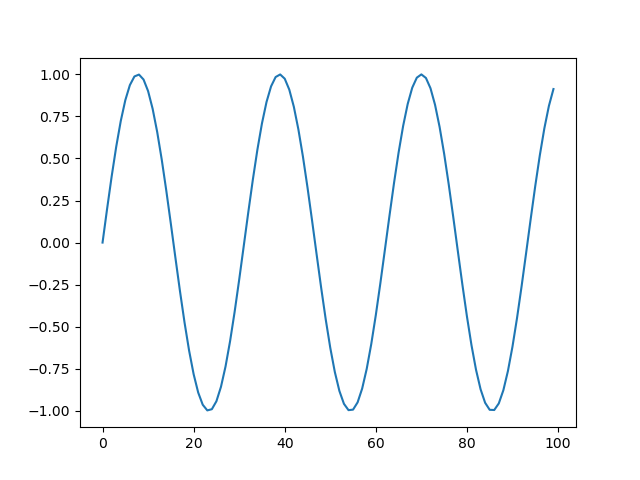

AttributeError: 'Canvas' object has no attribute 'key_press_event'

AttributeError: 'Canvas' object has no attribute 'key_press_event'

AttributeError: 'Canvas' object has no attribute 'key_release_event'

AttributeError: 'Canvas' object has no attribute 'key_release_event'

In [12]:
%matplotlib widget
# Testing matplotlib interactions with a simple plot
fig = plt.figure()
plt.plot(np.sin(np.linspace(0, 20, 100)));

# Always hide the toolbar
fig.canvas.toolbar_visible = False

# Put it back to its default
fig.canvas.toolbar_visible = 'fade-in-fade-out'

# Change the toolbar position
fig.canvas.toolbar_position = 'top'

# Hide the Figure name at the top of the figure
fig.canvas.header_visible = False

# Hide the footer
fig.canvas.footer_visible = False

# Disable the resizing feature
fig.canvas.resizable = False

# If true then scrolling while the mouse is over the canvas will not move the entire notebook
fig.canvas.capture_scroll = True

# You can also call display on fig.canvas to display the interactive plot anywhere in the notebook

fig.canvas.toolbar_visible = True
# display(fig.canvas)

# Or you can display(fig) to embed the current plot as a png
# display(fig)



In [ ]:

nstocks = len(banks)
sharpeTrains = np.zeros((nstocks,nstocks))
sharpeTests = np.zeros((nstocks,nstocks))
cointTests = np.zeros((nstocks, nstocks))

for i in range(0,len(banks)-1):
    for j in range(i+1,len(banks)):
        print('The pair under investigation is ',banks[i],banks[j])
        pairtrade = pairtrading(banks[i],banks[j],'Open')
        pairtrade.analysis_period = '2y'
        # pairtrade.getdata()
        pairtrade.teststrategy(330, 1, 0.5)
        
        sharpeTrains[i,j] = pairtrade.SharpeTrain
        sharpeTests[i,j] = pairtrade.SharpeTest
        if pairtrade.co_integration == 1:
            cointTests[i,j] = 1
        print('\n\n')

Indices of sharpe-trains are (5, 9)
Indices of sharpe-tests are (2, 9)


C:\Users\sadri\AppData\Local\Temp\ipykernel_15416\1193077797.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


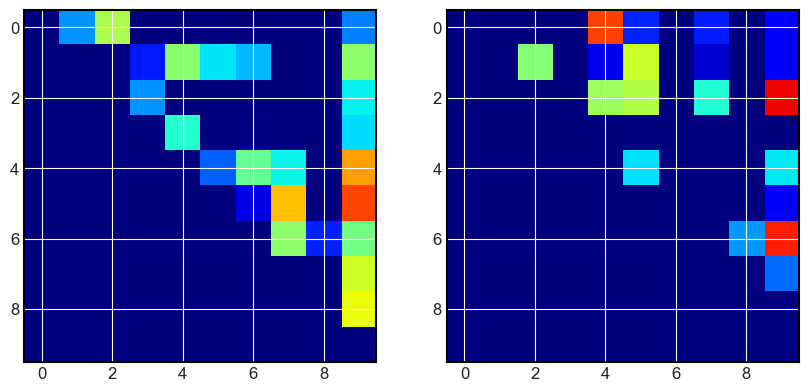

In [112]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(sharpeTrains, vmin = 1, vmax = 3, cmap = 'jet')
axs[1].imshow(sharpeTests, vmin = 1, vmax = 3, cmap = 'jet')
for i in range(2):
    axs[i].grid(True)
plt.ion()
fig.show()
# fig.colorbar()
# plt.ion()

print(f'Indices of sharpe-trains are {np.unravel_index(np.argmax(sharpeTrains, axis=None), sharpeTrains.shape)}')
print(f'Indices of sharpe-tests are {np.unravel_index(np.argmax(sharpeTests, axis=None), sharpeTests.shape)}')

In [83]:
print(f'Sharpe ratio of train and test set at [1,3] are {sharpeTrains[1,3]:.4f} and {sharpeTests[1,3]:.4f}, respectively!')
print(f'Relative banks are {banks[1]} and {banks[3]}.')

Sharpe ratio of train and test set at [1,3] are 1.8861 and 1.9461, respectively!
Relative banks are ISCTR.IS and GARAN.IS.


1.9460936973627478

In [67]:
banks[1]
banks[3]


'GARAN.IS'